# Add the lasa.py file in same directory as the jupyter notebook

In [34]:
!pip install gmr
import numpy as np
import matplotlib.pyplot as plt
from lasa import load_lasa
import gmr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: C:\Users\sengu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Helper Functions for plotting and loading data

In [35]:
def plot_curves(x,show_start_end=True,**kwargs):
    '''
    plots 2d curves of trajectories

    params:
        x: array of shape (number of curves,n_steps_per_curve,2)
    '''
    if show_start_end:
        start_label,end_label = "start","end"
    else:
        start_label,end_label = None,None
    for t in range(x.shape[0]):
        plt.scatter(x[t][0,0],x[t][0,1],c='k',label=start_label)
        plt.scatter(x[t][-1,0],x[t][-1,1],c='b',label=end_label)
        plt.plot(x[t][:,0],x[t][:,1],**kwargs)
        if t==0:
            kwargs.pop("label",None)
            start_label,end_label = None,None

    plt.legend()


def streamplot(f,x_axis=(0,100),y_axis=(0,100),n=1000,width=1,**kwargs):
    '''
    helps visualizing the vector field.

    params:
        f: function to predict the velocities in DS(Dynamical system : x_dot = f(x),x of shape (n_points,2),x_dot of shape (n_points,2))
        x_axis: x axis limits
        y_axis: y axis limits
        n: number of points in each axis (so total n*n predictions happen)
        width: width of the vector
        **kwargs: goes into plt.streamplot
    '''
    a,b = np.linspace(x_axis[0],x_axis[1],n),np.linspace(y_axis[0],y_axis[1],n)
    X,Y = np.meshgrid(a,b)
    X_test = np.stack([X,Y],axis=-1).reshape(-1,2)
    Y_pred = f(X_test)
    U,V = np.split(Y_pred.reshape(n,n,2),2,axis=-1)
    U,V = U[...,0],V[...,0]
    speed = np.sqrt(U**2+V**2)
    lw = width*speed / speed.max()
    plt.streamplot(X,Y,U,V,linewidth=lw,**kwargs)

#gets the velocity x_dot given x
def derivative(x):
    '''
    difference method for calculating derivative

    params:
      x: array of shape (number of trajectories,number of timesteps,2)

    returns
      xd: array of shape (number of trajectories,number of timesteps,2)
    '''
    xds = []

    for i in range(x.shape[0]):
        dt = 1/(x[i].shape[0]-1)
        xd = np.vstack((np.diff(x[i], axis=0) / dt,np.zeros((1, x[i].shape[1]))))
        v_factor = np.cos(np.linspace(0,np.pi/2,len(xd)))**2
        xd = xd*(v_factor[...,None])
        xds.append(xd)
    xd = np.stack(xds)
    return xd

#loading the data and plotting
def load_data(letter):
    '''
    gets the trajectories coresponding to the given letter

    params:
      letter: character in ["c","j","s"]

    returns:
      data: array of shape (number of trajectories,number of timesteps,2)
      x: array of shape(number of trajectories*number of timesteps,2)
      xd: array of shape(number of trajectories*number of timesteps,2)

    '''
    letter2id = dict(c=2,j=6,s=24)
    assert letter.lower() in letter2id
    _,x,_,_,_,_ = load_lasa(letter2id[letter.lower()])
    xd = derivative(x)
    plot_curves(x)
    data = x
    x = x.reshape(-1,2)
    xd = xd.reshape(-1,2)
    plt.show()
    return data,x,xd

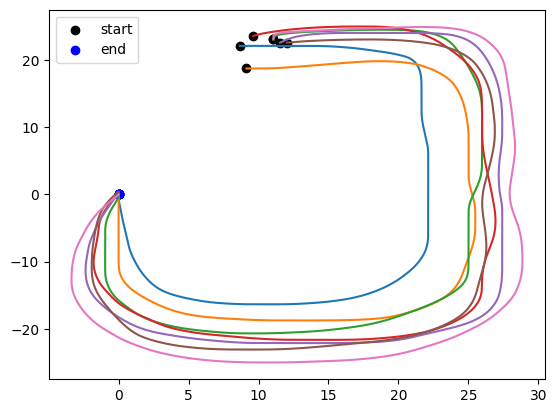

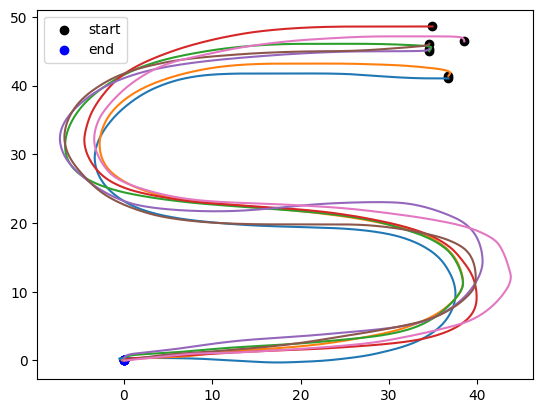

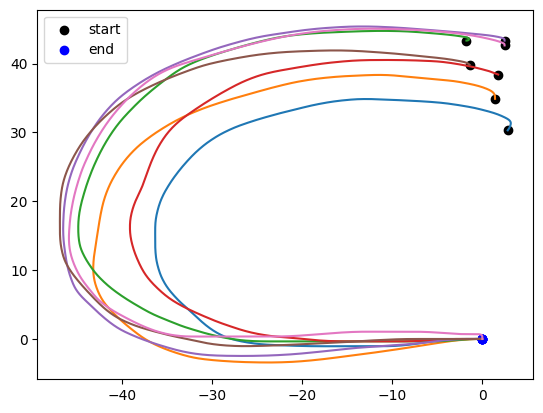

In [36]:
#letter should be one of c,j,s
data,x,xd = load_data("j")
data,x,xd = load_data("s")
data,x,xd = load_data("c")

# GPR (Gaussian Process Regression)

In [37]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

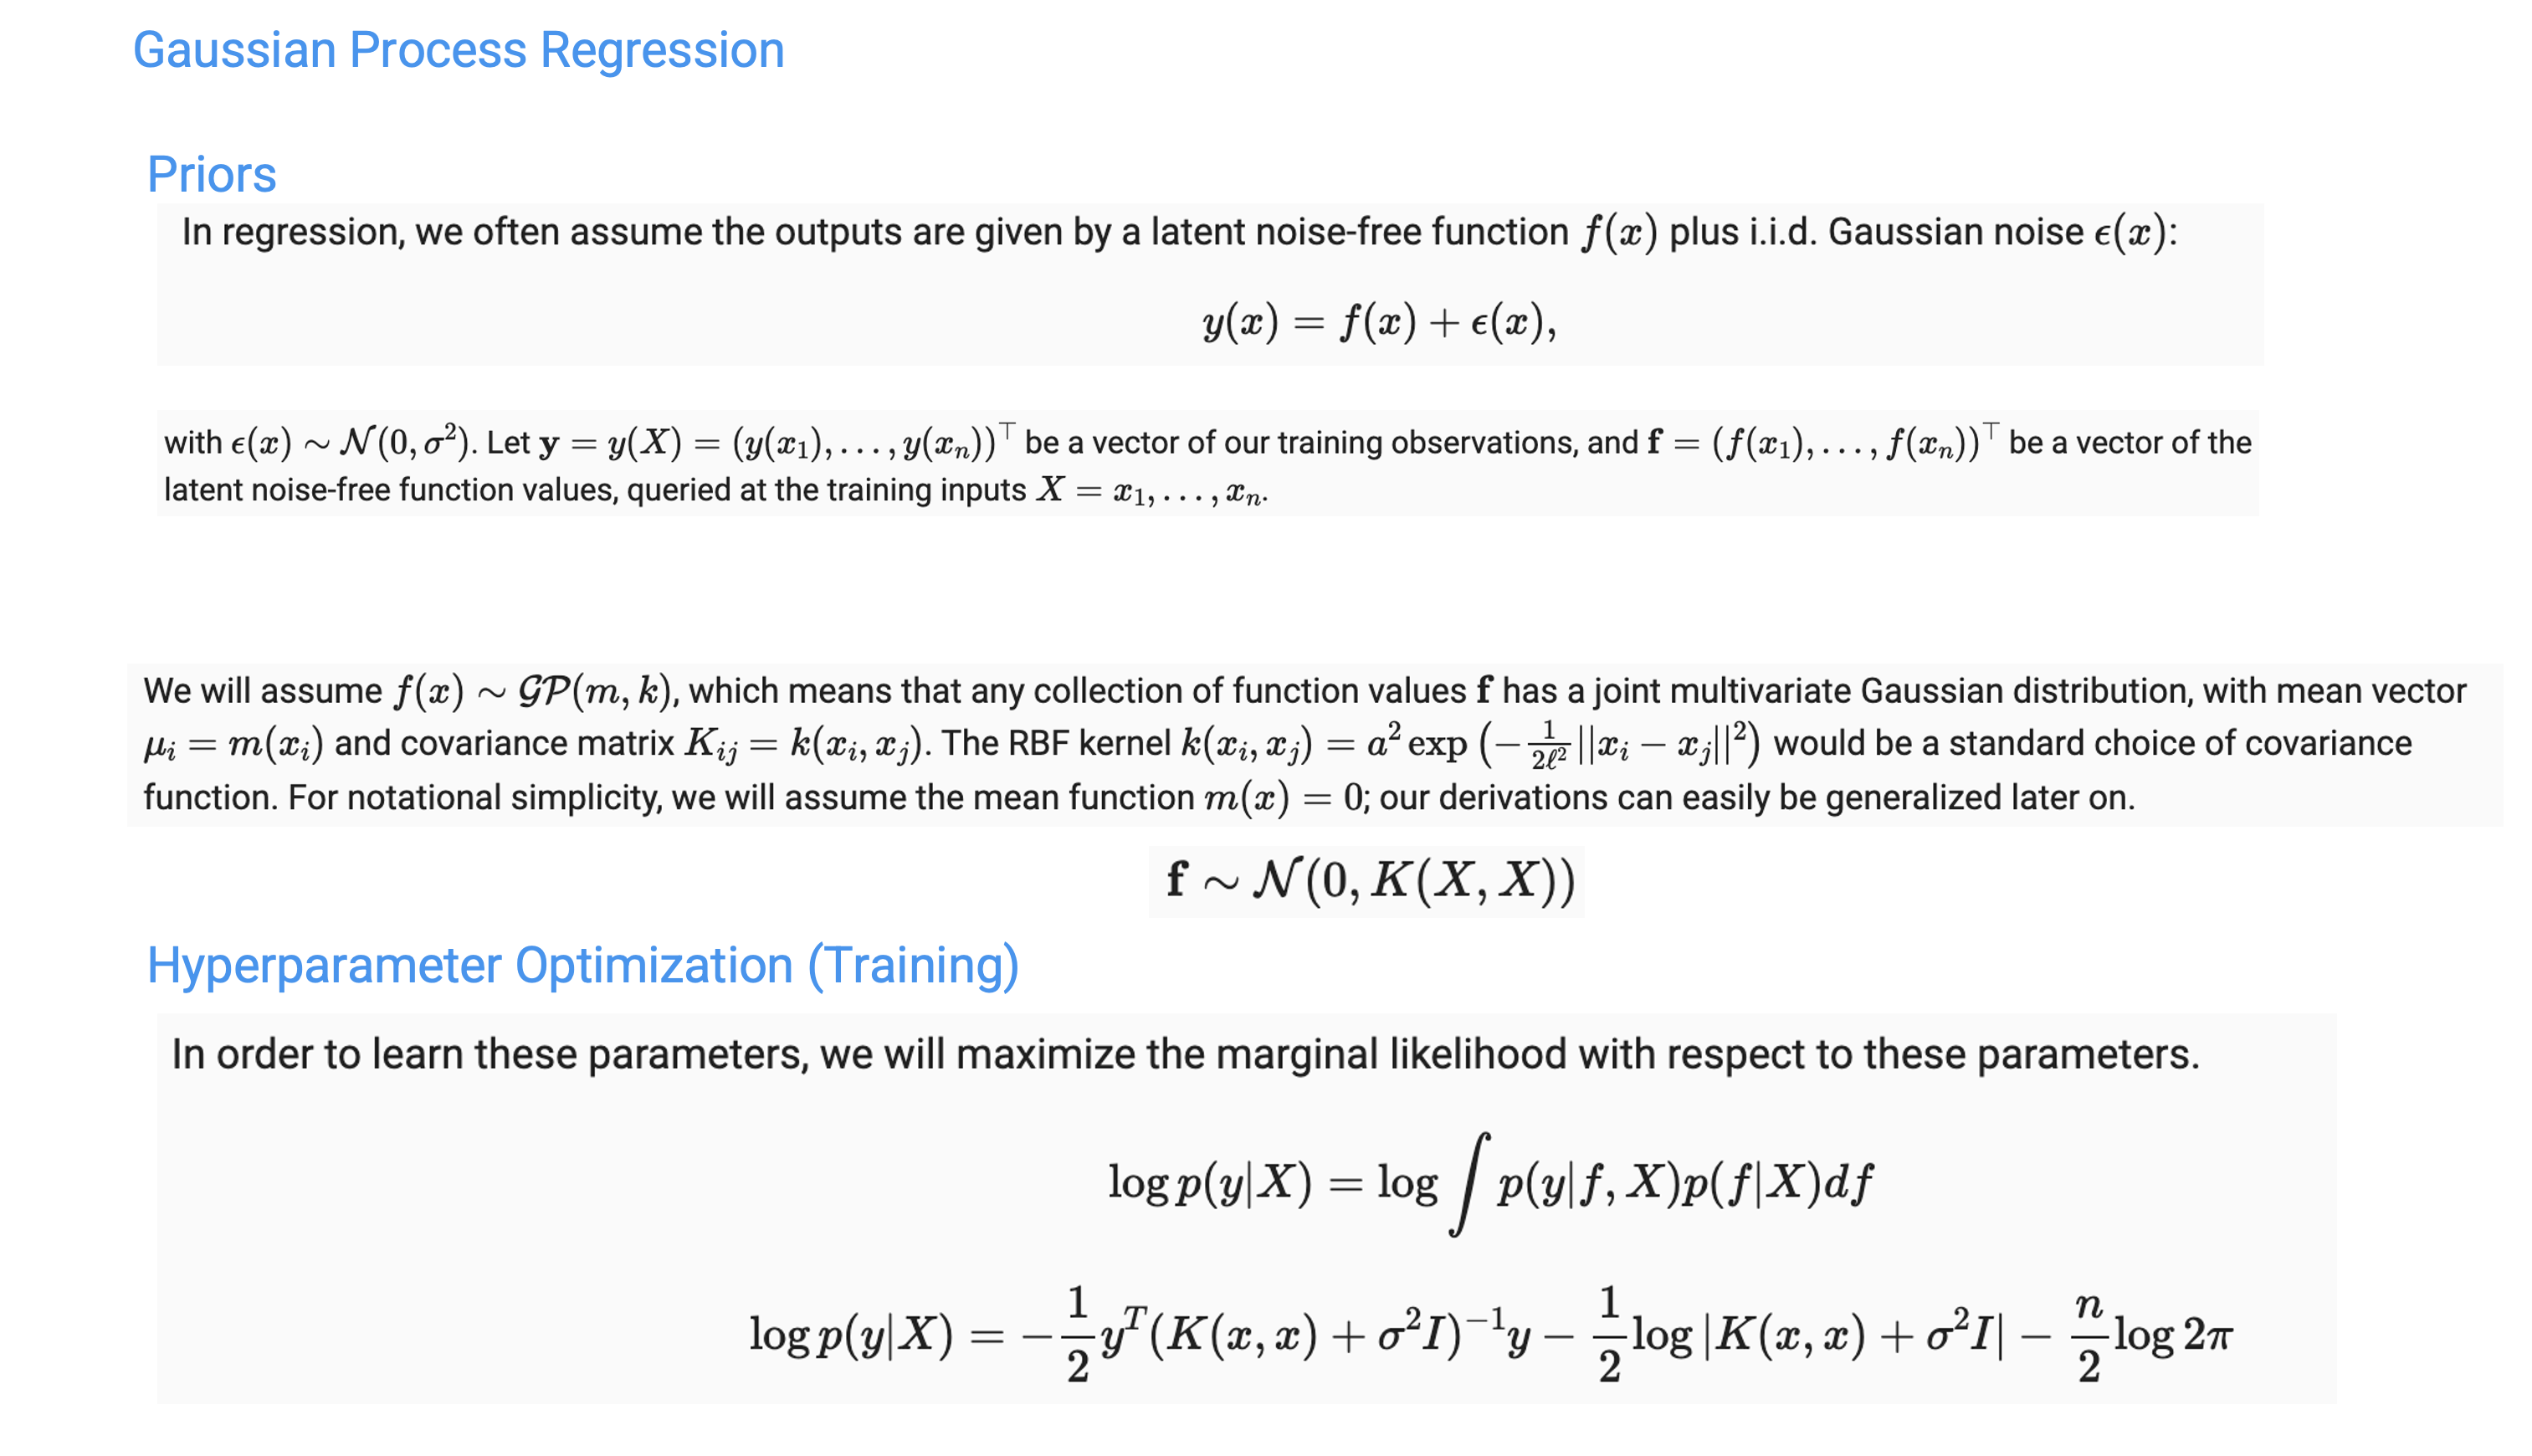

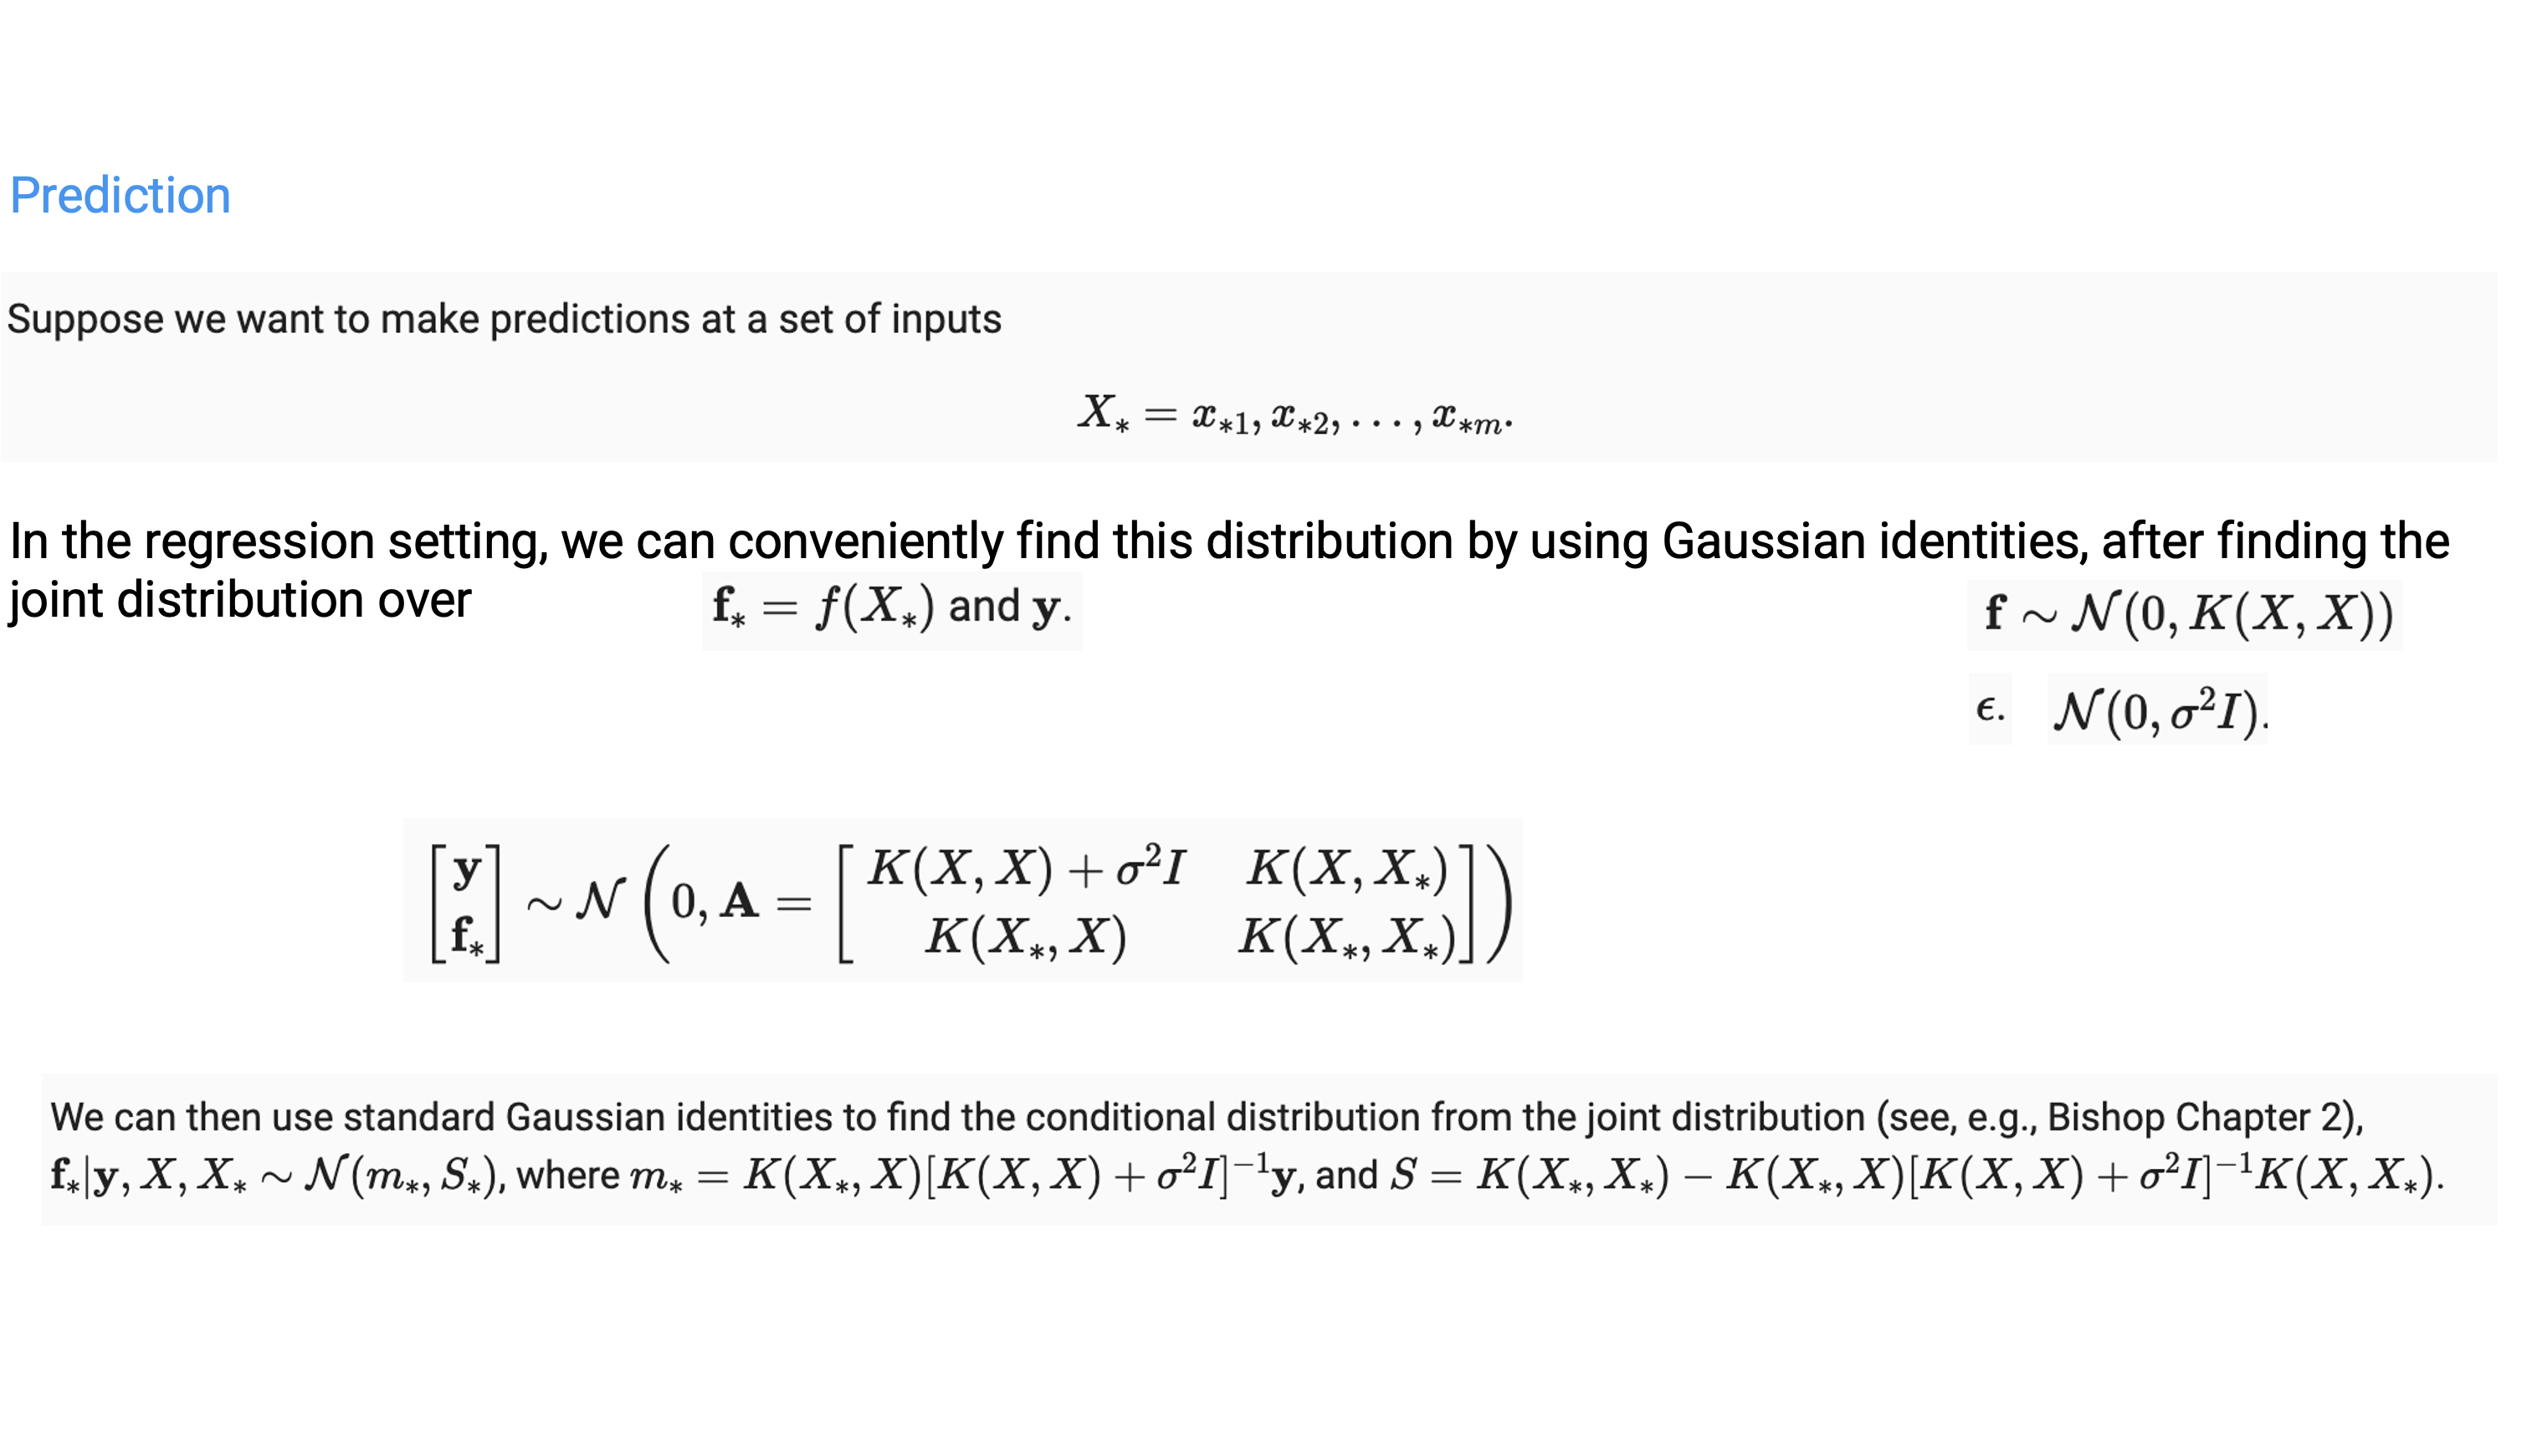

In [43]:
class GPR:
    def __init__(self, kernel, **kwargs):
        self.gpr = GaussianProcessRegressor(kernel=kernel, **kwargs)
        self.is_fitted = False

    def sample(self, X):
        """
        Used by streamplot.

        Before fitting → sample from GP prior
        After fitting  → return posterior mean
        """

        # PRIOR
        if not self.is_fitted:
            K = self.gpr.kernel(X)  # K(X,X)
            K = K + 1e-6 * np.eye(K.shape[0])  # jitter

            # sample 2D output
            L = np.linalg.cholesky(K)
            z = np.random.randn(K.shape[0], 2)
            return L @ z

        # POSTERIOR
        return self.predict(X)

    def fit(self, X, Y):
        self.gpr.fit(X, Y)

        self.X_train = X
        self.Y_train = Y

        K = self.gpr.kernel(X)
        sigma2 = self.gpr.alpha if np.isscalar(self.gpr.alpha) else np.mean(self.gpr.alpha)

        # Cholesky for numerical stability
        self.L = np.linalg.cholesky(K + sigma2 * np.eye(K.shape[0]))
        self.alpha_vec = np.linalg.solve(
            self.L.T,
            np.linalg.solve(self.L, Y)
        )

        self.is_fitted = True

    def predict(self, X_star):
        K_star = self.gpr.kernel(X_star, self.X_train)
        return K_star @ self.alpha_vec

    def ode_differential(self,x,t):
        return self.predict(x[None])[0]

    def rk4_sim(self,t0,t_end,x0,f,dt=1e-3):
        x,t = x0,t0
        x_list,t_list = [x0],[t0]
        while t<=t_end:
            k1 = dt*f(x,t)
            k2 = dt*f(x+k1/2.,t+dt/2. )
            k3 = dt*f(x+k2/2.,t+dt/2. )
            k4 = dt*f(x+k3 , t+dt )
            x = x + 1./6*(k1+2*k2+2*k3+k4)
            t = t + dt
            x_list.append(x)
            t_list.append(t)
        return np.array(x_list),np.array(t_list)

    def imitate(self,x0,t_end=5):
        f = self.ode_differential
        return self.rk4_sim(0,t_end,x0,f)

In [44]:
#choose kernel
kernel = RBF(length_scale=1.0)

In [45]:
#number of trajectories selected for training
n=1
x_new = x.reshape(*data.shape)
x_new = x_new[:n].reshape(-1,2)
xd_new = xd.reshape(*data.shape)
xd_new = xd_new[:n].reshape(-1,2)

In [46]:
#fitting the model to data,alpha is noise
model = GPR(kernel,alpha=1,)

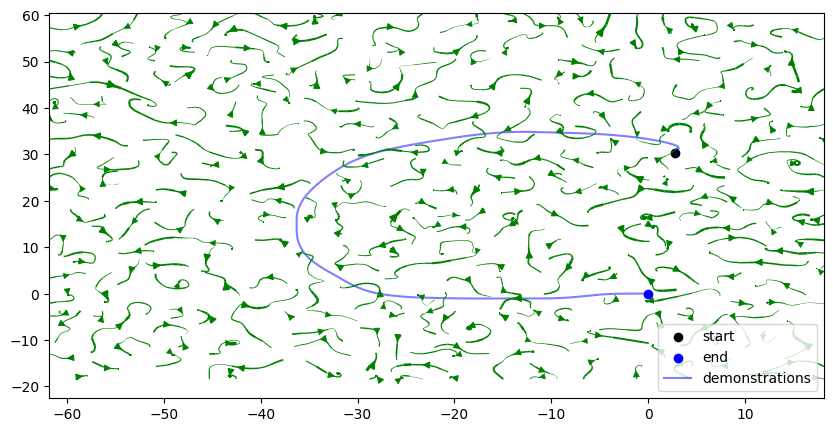

In [47]:
plt.figure(figsize=(10,5))
plot_curves(data[:n],alpha=0.5,c="b",label="demonstrations")

streamplot(
    model.sample,
    x_axis=(min(x[:,0])-15,max(x[:,0])+15),
    y_axis=(min(x[:,1])-15,max(x[:,1])+15),
    width=3,
    color="g",
    n=50
)


In [48]:
#fit the model
model.fit(x_new,xd_new)

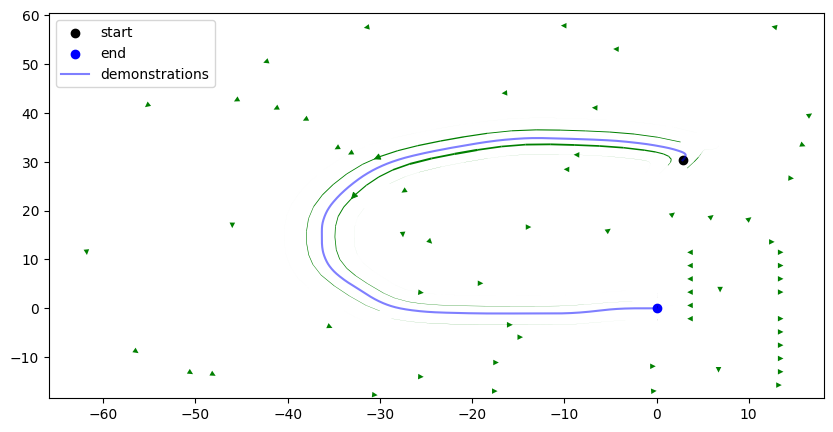

In [49]:
#vector field plot using stream line, sample from posterior
plt.figure(figsize=(10,5))
plot_curves(data[:n],alpha=0.5,c="b",label="demonstrations")
streamplot(model.sample,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g",n=50)

In [50]:
#new starting point for imitation
x0 = data[n-1][0]
x_rk4,t_tk4 = model.imitate(x0,t_end=5)

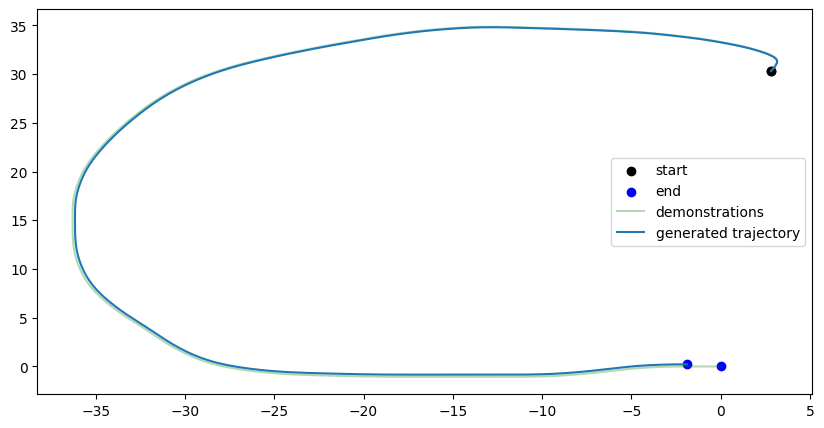

In [51]:
#plots for generated trajectory
plt.figure(figsize=(10,5))
plot_curves(data[:n],alpha=0.3,c="g",label="demonstrations")
plot_curves(x_rk4[None],show_start_end=False,label="generated trajectory")

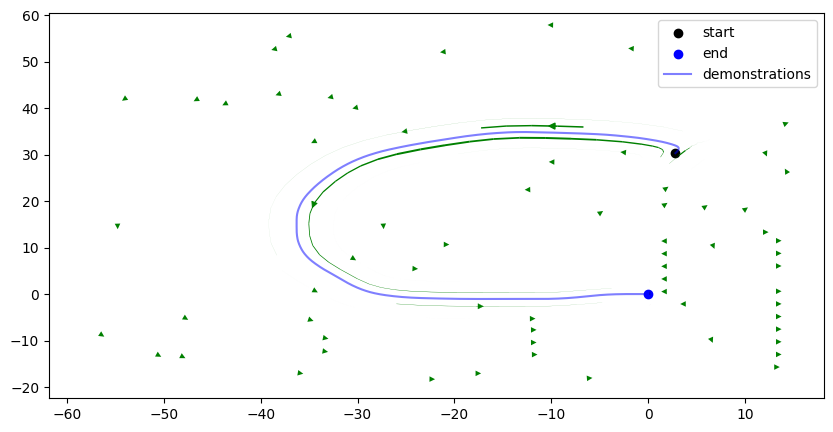

In [ ]:
#vector field plot using stream line
plt.figure(figsize=(10,5))
plot_curves(data[:n],alpha=0.5,c="b",label="demonstrations")
streamplot(model.predict,x_axis=(min(x[:,0])-15,max(x[:,0])+15),y_axis=(min(x[:,1])-15,max(x[:,1])+15),width=3,color="g",n=100)

#Fit the model to each of the data set and answer the following questions:

**For "C" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans: Near the demonstrations, the system is locally stable and converges to the sink. Far from data, the predictive mean reverts to zero (if zero mean prior), which means the velocity becomes zero, acting as equilibrium points potentially everywhere outside the data support. Thus, it is NOT Global Asymptotically Stable in the strict sense without mean function design.

Q2.Try different initial points, and simulate the process.

Q3.Try different kernels and comment on the generalization of the algorithm. \\
Ans: When different kernels were tested for the C dataset, the influence of the length scale parameter became evident. A small RBF length scale allowed the model to closely follow the demonstrated curvature but risked overfitting, as suggested by the convergence warnings where the optimal length scale approached the lower bound. A larger RBF length scale produced smoother global behavior but reduced sensitivity to local curvature. The Matern kernel generated slightly rougher trajectories and handled curvature transitions with moderate flexibility. Overall, kernel selection significantly affected smoothness and generalization, but none of the configurations yielded strict global stability.

**For "J" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans: The hook-shaped “J” is captured clearly.
The vector field near demonstrations directs trajectories properly.
Outside the data region, streamlines flatten or form mild drift. Therefore we can say that not strictly GAS.Locally stable, but global convergence is not guaranteed.

Q2.Try different initial points, and simulate the process.

Q3.Try different kernels and comment on the generalization of the algorithm. \\
Ans: Kernel variation for the J dataset produced similar qualitative behavior to the C dataset. The RBF kernel with an appropriately chosen length scale captured the overall shape well, while smaller length scales increased sensitivity to local details and larger ones oversmoothed the curvature. The Matern kernel allowed slightly sharper transitions in the hook region. The general behavior remained consistent across kernels, though stability remained local rather than global.

**For "S" Dataset:**

Q1.Does the system have a GAS (Global asymptotic Stable) Point ? Explain. \\
Ans: The S dataset presents the most challenging case. The streamline visualization shows that the S-shaped curvature is reproduced in the region of demonstrations, but the vector field outside this region contains areas of weak magnitude and irregular flow. The random start simulations further illustrate that some initial conditions converge to the demonstrated trajectory, while others drift or follow distorted paths.Consequently, the learned system for the S dataset clearly does not exhibit global asymptotic stability and has the smallest effective basin of attraction among the three datasets.

Q2.Try different initial points, and simulate the process.

Q3.Try different kernels and comment on the generalization of the algorithm. \\
Ans: S requires a kernel that can model the changing curvature. RBF works well. Length scale needs to be small enough to distinguish the two curves of S but large enough to connect them.


--- Analysis for Dataset C ---


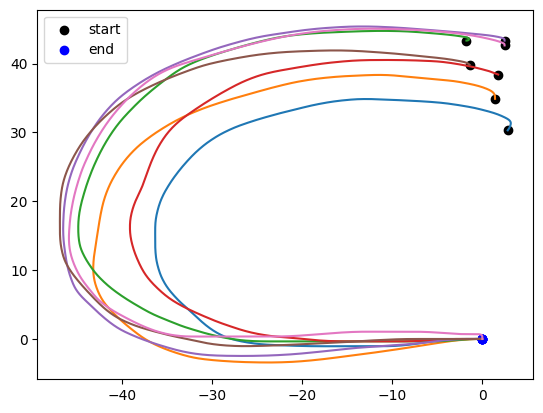

c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


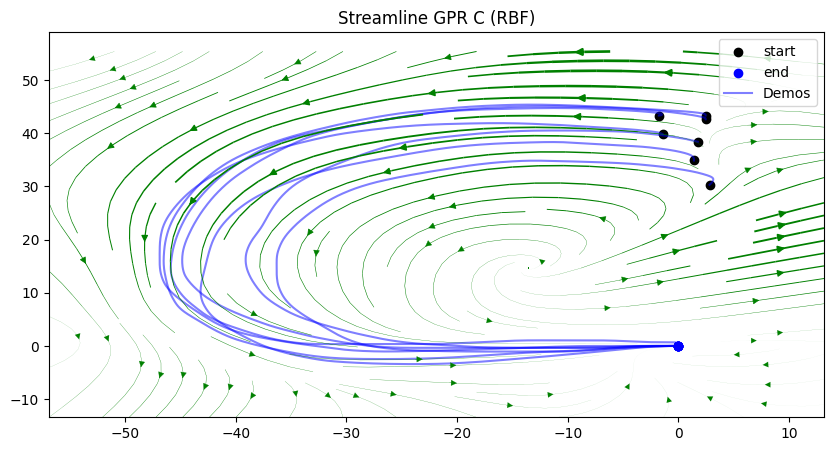

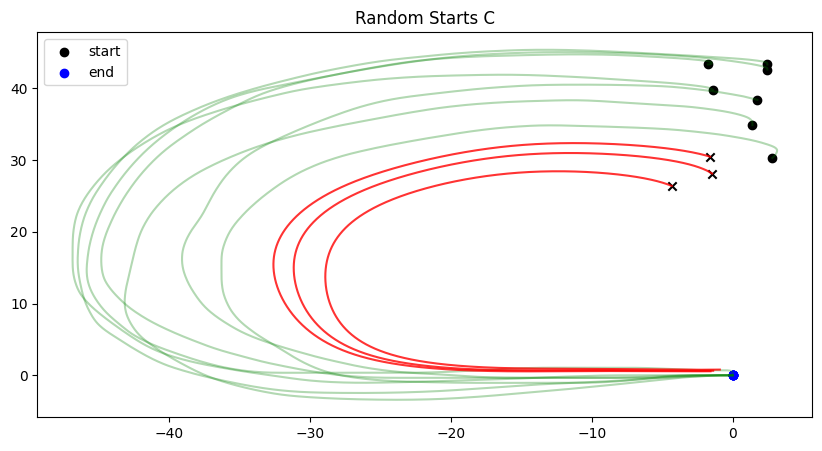

C:\Users\sengu\AppData\Local\Temp\ipykernel_28176\2603493841.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sengu\AppData\Local\Temp\ipykernel_28176\2603493841.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The opti

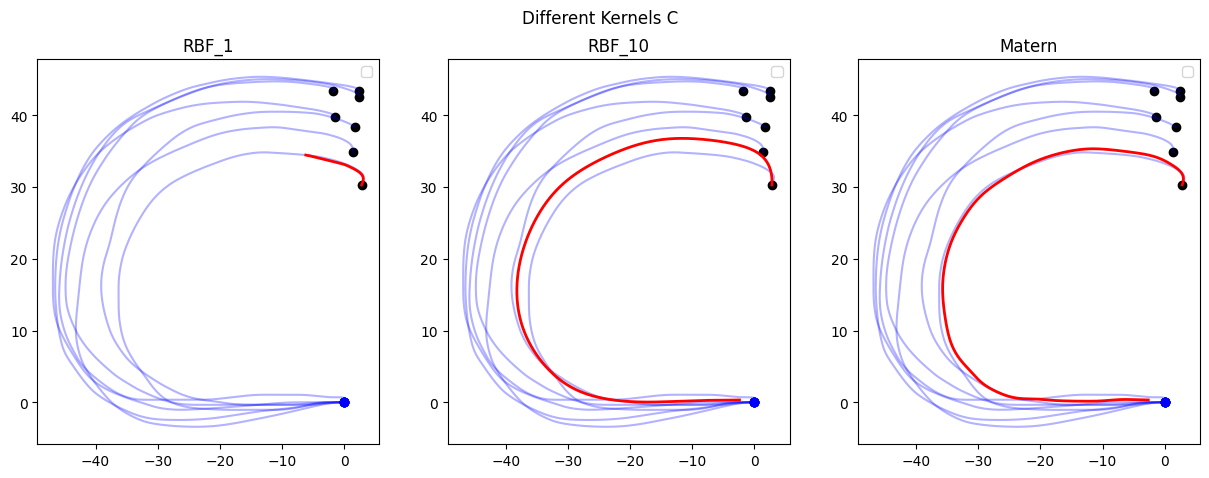

--- Analysis for Dataset J ---


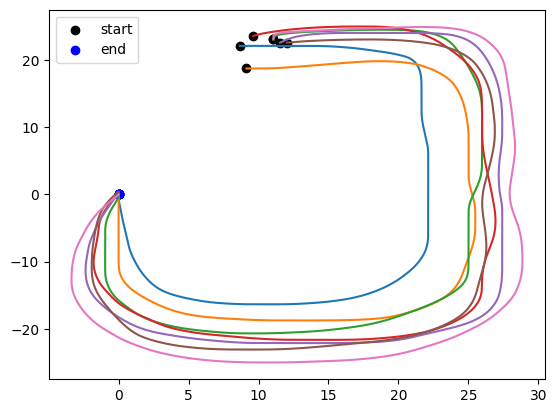

c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


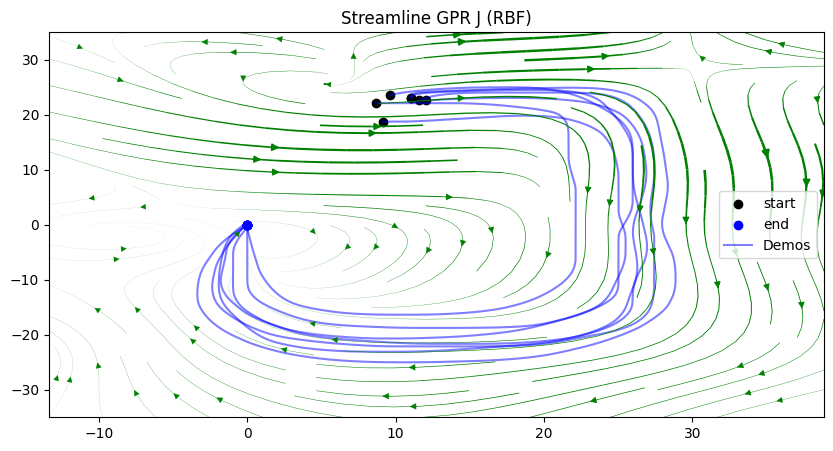

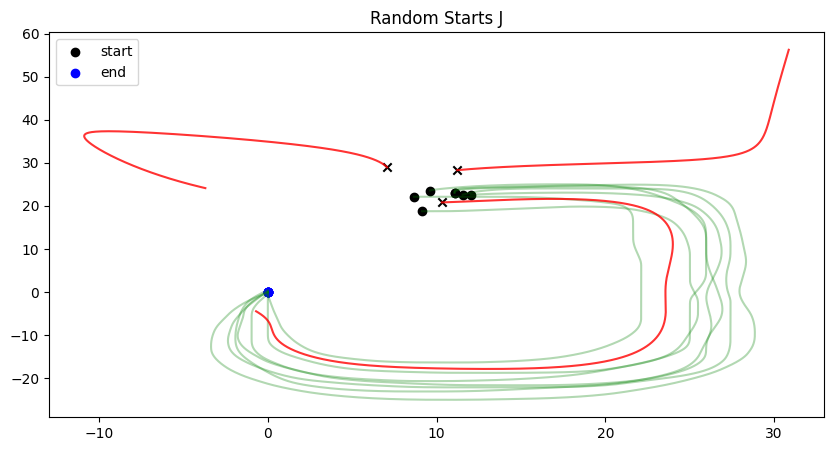

C:\Users\sengu\AppData\Local\Temp\ipykernel_28176\2603493841.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sengu\AppData\Local\Temp\ipykernel_28176\2603493841.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The opti

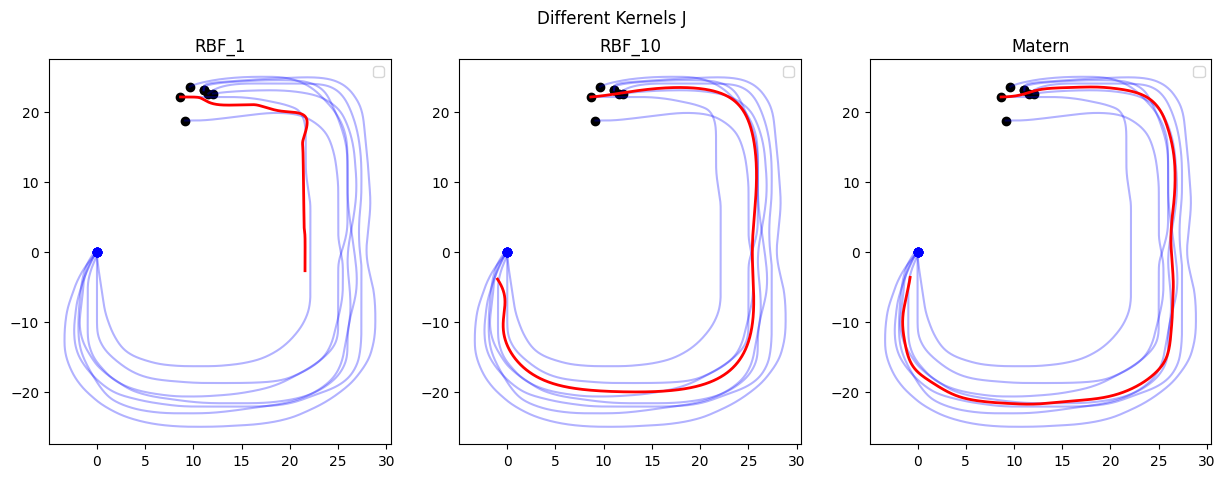

--- Analysis for Dataset S ---


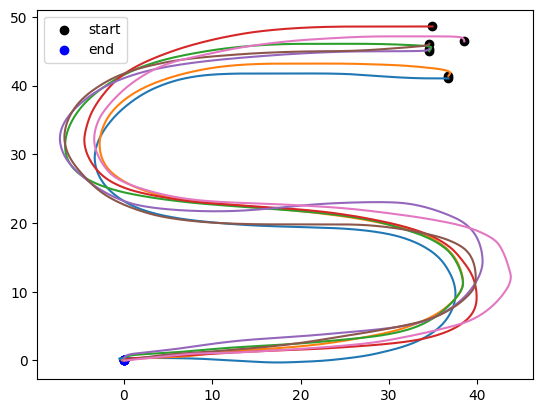

c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


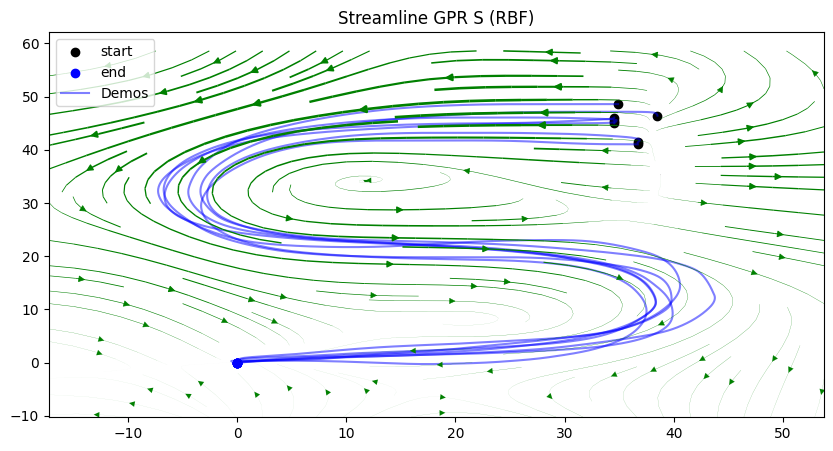

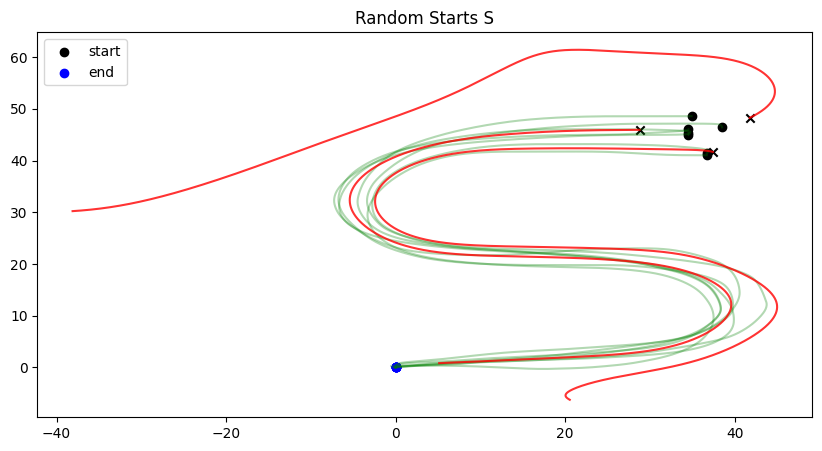

C:\Users\sengu\AppData\Local\Temp\ipykernel_28176\2603493841.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\sengu\AppData\Local\Temp\ipykernel_28176\2603493841.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\sengu\OneDrive\Desktop\IL\CP321_Imitation_Learning\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The opti

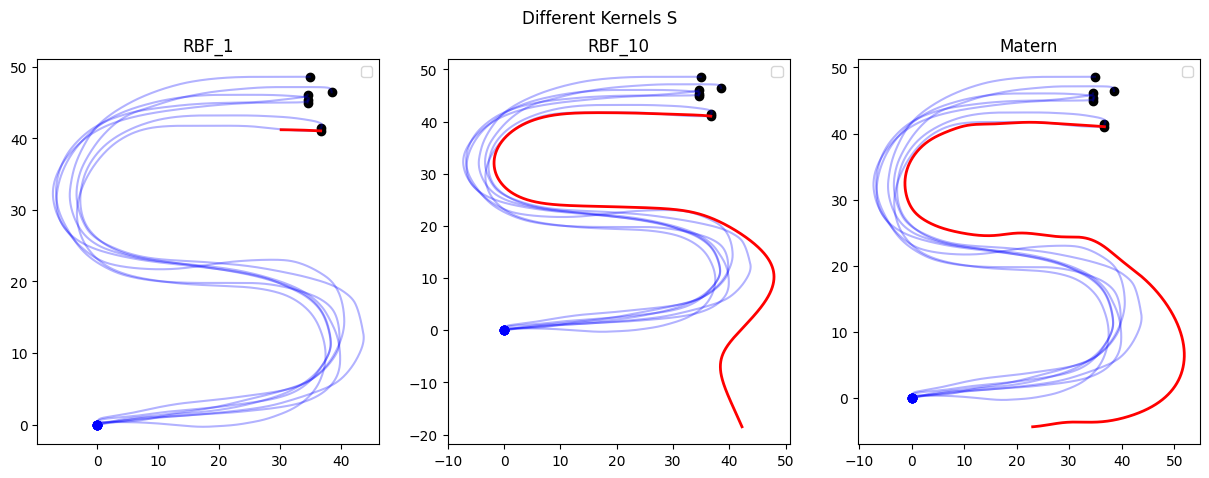

In [ ]:
for letter in ['c', 'j', 's']:
    print(f"--- Analysis for Dataset {letter.upper()} ---")
    data_l, x_l, xd_l = load_data(letter)
    
    # Subsample for GPR (O(N^3))
    # Randomly select N points or decimate
    N = 100
    indices = np.linspace(0, len(x_l)-1, N, dtype=int)
    x_sub = x_l[indices]
    xd_sub = xd_l[indices]
    
    # Q1: Stability with RBF
    kernel = RBF(length_scale=10.0)
    model_l = GPR(kernel, alpha=0.01)
    model_l.fit(x_sub, xd_sub)
    
    plt.figure(figsize=(10, 5))
    plt.title(f"Streamline GPR {letter.upper()} (RBF)")
    plot_curves(data_l, alpha=0.5, c="b", label="Demos")
    arr_x = x_l[:, 0]; arr_y = x_l[:, 1]
    x_range = (np.min(arr_x)-10, np.max(arr_x)+10)
    y_range = (np.min(arr_y)-10, np.max(arr_y)+10)
    streamplot(model_l.sample, x_axis=x_range, y_axis=y_range, width=2, color="g")
    plt.show()
    
    # Q2: Random Starts
    plt.figure(figsize=(10, 5))
    plt.title(f"Random Starts {letter.upper()}")
    plot_curves(data_l, alpha=0.3, c="g")
    for _ in range(3):
        x0_noisy = data_l[0][0] + np.random.normal(0, 5, 2)
        try:
            x_sim, _ = model_l.imitate(x0_noisy, t_end=5)
            plt.plot(x_sim[:, 0], x_sim[:, 1], 'r-', alpha=0.8)
            plt.scatter(x_sim[0, 0], x_sim[0, 1], c='k', marker='x')
        except:
            pass
    plt.show()
    
    # Q3: Kernels
    kernels = [
        ('RBF_1', RBF(1.0)),
        ('RBF_10', RBF(10.0)),
        ('Matern', Matern(length_scale=10.0, nu=1.5))
    ]
    plt.figure(figsize=(15, 5))
    for i, (name, k) in enumerate(kernels):
        plt.subplot(1, 3, i+1)
        m_k = GPR(k, alpha=0.01)
        m_k.fit(x_sub, xd_sub)
        plot_curves(data_l, alpha=0.3, c="b", show_start_end=False)
        # Simulate
        try:
            x_sim, _ = m_k.imitate(data_l[0][0], t_end=5)
            plt.plot(x_sim[:, 0], x_sim[:, 1], 'r-', linewidth=2)
        except:
            pass
        plt.title(f"{name}")
    plt.suptitle(f"Different Kernels {letter.upper()}")
    plt.show()


# Submission details

please submit the copy of this file with the naming convention **SRNO(5digit)_Assignment6.ipynb**